# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN.

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим?

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

100%|██████████| 170M/170M [00:04<00:00, 39.1MB/s]


Посмотрим на изображения:

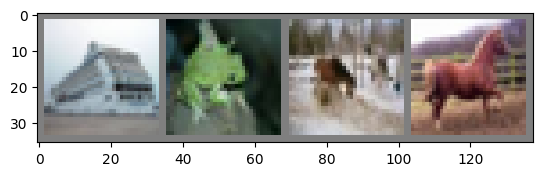

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
class BasicBlockNet(nn.Module):
    def __init__(self):
        super(BasicBlockNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=32)

        self.conv_shortcut = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)

        self.avgpool = nn.AvgPool2d(kernel_size=8)
        self.fc = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        out_1 = self.conv1(x)
        out_1 = self.bn1(out_1)
        out_1 = self.relu(out_1)

        out_1 = self.conv2(out_1)
        out_1 = self.bn2(out_1)

        out_2 = self.conv_shortcut(x)

        out = out_1 + out_2
        out = self.relu(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [ ]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [21]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = torch.nn.functional.cross_entropy(output, target)

            loss_log.append(loss.item())

            preds = output.argmax(dim=1)
            acc = (preds == target).float().mean()
            acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)

        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        preds = output.argmax(dim=1)
        acc = (preds == target).float().mean()
        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.4626788326983478, train acc: 0.4791721076154622
 val loss: 1.1944007247052295, val acc: 0.5773714539852548

Epoch 1
 train loss: 1.1575028348230574, train acc: 0.5939581157738374
 val loss: 1.1196494105014396, val acc: 0.6148049646235527

Epoch 2
 train loss: 1.0478028038302114, train acc: 0.6364463633113631
 val loss: 1.1025294674203752, val acc: 0.621099290949233

Epoch 3
 train loss: 0.990898693610371, train acc: 0.6562785648994516
 val loss: 1.0296792121643716, val acc: 0.6422650710065314

Epoch 4
 train loss: 0.9529578308736603, train acc: 0.6690511557476176
 val loss: 0.9941641959738224, val acc: 0.6552083335024246

Epoch 5
 train loss: 0.9298792477063766, train acc: 0.6765433207726348
 val loss: 0.9410156602555133, val acc: 0.6769503547790202

Epoch 6
 train loss: 0.9034947785642509, train acc: 0.6844517172363602
 val loss: 1.0847790139786742, val acc: 0.6355718085106383

Epoch 7
 train loss: 0.8826577816519484, train acc: 0.6923845978062158
 val loss: 0.9

Посчитайте точность на тестовой выборке:

In [ ]:
net.eval()
test_loss, test_accuracy = test(net, test_loader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 0.9028025759253532, Test Accuracy: 0.6905851910828026


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

Epoch 0
 train loss: 0.6419423616455504, train acc: 0.7746841539194641
 val loss: 0.8738841378942449, val acc: 0.7100398936170212

Epoch 1
 train loss: 0.6374944708356037, train acc: 0.7749738835983346
 val loss: 0.859724491961459, val acc: 0.7125664893617021

Epoch 2
 train loss: 0.6409083188015975, train acc: 0.7773978193673616
 val loss: 0.8514637344695152, val acc: 0.7138076241980208

Epoch 3
 train loss: 0.6380899179134334, train acc: 0.7761287216294618
 val loss: 0.8615843833761012, val acc: 0.7096852837724889

Epoch 4
 train loss: 0.6307726035497306, train acc: 0.7780711347921675
 val loss: 0.8929330171422756, val acc: 0.7091090425531915

Epoch 5
 train loss: 0.6265785967628088, train acc: 0.7807031862260655
 val loss: 0.8498578112176124, val acc: 0.7217420212765957

Epoch 6
 train loss: 0.6252525290252957, train acc: 0.7798339971894538
 val loss: 0.8714073447470969, val acc: 0.7147828015875309

Epoch 7
 train loss: 0.6240116884111269, train acc: 0.7827598589865773
 val loss: 0.

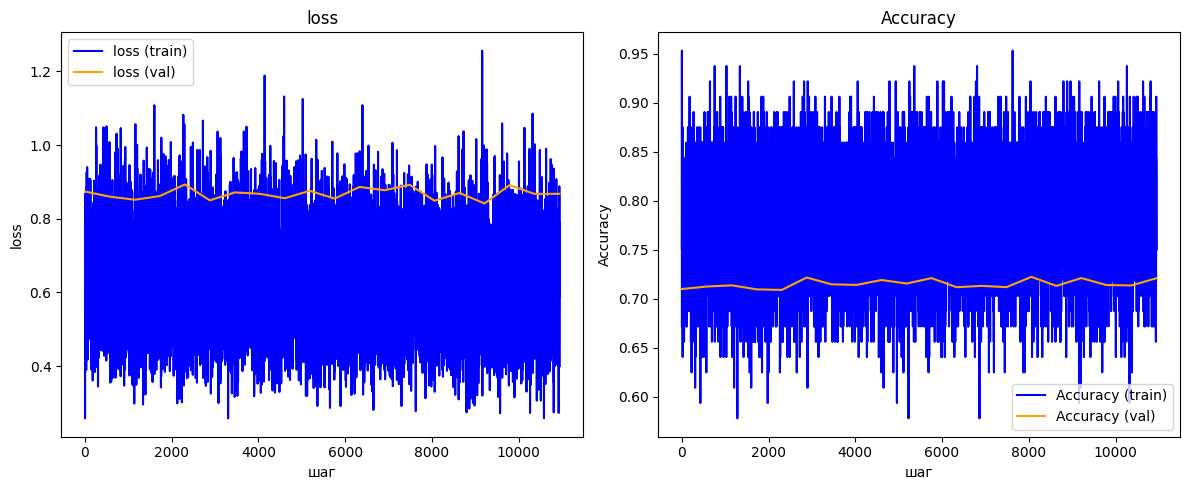

In [ ]:
n_epochs = 20

def plot_metrics(train_loss_log, train_acc_log, val_loss_log, val_acc_log):
    steps = np.arange(1, len(train_loss_log) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(steps, train_loss_log, label='loss (train)', color='blue')

    val_steps = np.linspace(1, len(train_loss_log), len(val_loss_log))
    plt.plot(val_steps, val_loss_log, label='loss (val)', color='orange')
    plt.title('loss')
    plt.xlabel('шаг')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(steps, train_acc_log, label='Accuracy (train)', color='blue')

    plt.plot(val_steps, val_acc_log, label='Accuracy (val)', color='orange')
    plt.title('Accuracy')
    plt.xlabel('шаг')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

plot_metrics(train_loss_log, train_acc_log, val_loss_log, val_acc_log)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.516011006217552, train acc: 0.4625799817184644
 val loss: 1.2581522266915504, val acc: 0.5600177305809995

Epoch 1
 train loss: 1.202969584539124, train acc: 0.5776638809244201
 val loss: 1.0809013419962943, val acc: 0.6219414893617021

Epoch 2
 train loss: 1.0662412203208185, train acc: 0.6298805171218607
 val loss: 1.074582641936363, val acc: 0.6278590425531915

Epoch 3
 train loss: 1.0038715944211705, train acc: 0.6526508226691042
 val loss: 1.0372825995404669, val acc: 0.6396719859001484

Epoch 4
 train loss: 0.962783728155837, train acc: 0.6653091539194641
 val loss: 0.9878803605728961, val acc: 0.6655585106382979

Epoch 5
 train loss: 0.930332325821167, train acc: 0.6791304844606947
 val loss: 0.9716297322131218, val acc: 0.6632757093044037

Epoch 6
 train loss: 0.9113012502136788, train acc: 0.6828561635514282
 val loss: 0.9770366798055933, val acc: 0.6634751773895101

Epoch 7
 train loss: 0.8927397585220267, train acc: 0.690372812791542
 val loss: 0.97490

Посчитайте точность на тестовой выборке:

In [ ]:
net.eval()
test_loss, test_accuracy = test(net, test_loader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 0.8421233611501706, Test Accuracy: 0.7104896496815286


__Комментарий:__ Уменьшение шага помоглу лучшить метрики. Accuracy на тестовой выборке вырос (с 0.69 до 0.71)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [10]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.8112980648194197, train acc: 0.36281503009621796
 val loss: 1.6004154976378095, val acc: 0.43947251781504204

Epoch 1
 train loss: 1.5151641214133618, train acc: 0.4695253330785134
 val loss: 1.4359950572886366, val acc: 0.49155585106382976

Epoch 2
 train loss: 1.393401203469341, train acc: 0.5142579656196469
 val loss: 1.342971546091932, val acc: 0.5267952127659574

Epoch 3
 train loss: 1.3242709017758831, train acc: 0.5337759533137683
 val loss: 1.312079091274992, val acc: 0.5379654255319148

Epoch 4
 train loss: 1.2699558667334603, train acc: 0.554334519550177
 val loss: 1.2651016184624204, val acc: 0.5582003546522019

Epoch 5
 train loss: 1.227771856231271, train acc: 0.5698248564216293
 val loss: 1.2535956189987507, val acc: 0.5573581561129144

Epoch 6
 train loss: 1.1857510174214294, train acc: 0.5877676939615601
 val loss: 1.1924775225050905, val acc: 0.5822251773895102

Epoch 7
 train loss: 1.157618075336791, train acc: 0.598022492864668
 val loss: 1.147

In [11]:
net.eval()
test_loss, test_accuracy = test(net, test_loader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 0.9517359555147256, Test Accuracy: 0.6671974522292994


__Комментарий:__ Качество работы модели действительно упало (с 0.71 до 0.67). Вполне вероятно это связано с тем, что шаг получается слишком маленьким, чтобы модель достатигла оптимума.

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

__Комментарий:__ Наиболее интересно протестировать работу следующих lr-шедьюлеров:
- ReduceLROnPlateau - он уменьшает lr если функция потерь не снижается в течение заданного количества эпох
- CosineAnnealingLR - уменьшает lr до 0 по косинусной функции, потом плавно восстанавливает к начальному количеству через заданное количество эпох.   
Чтобы лучше увидеть разницу, вначале увеличим количество эпох в бейслайне (для нас это MultiStepLR) до 40 и зафиксируем результат, потом для каждого шедьюлера также обучим 40 эпох и посмотрим на метрику Accuracy.

In [14]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 40, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 0.9871651922545006, train acc: 0.6572946592266424
 val loss: 1.012090886400101, val acc: 0.6473182624958931

Epoch 1
 train loss: 0.9745554612367201, train acc: 0.6618323975550845
 val loss: 0.9545249573727872, val acc: 0.6657801420130628

Epoch 2
 train loss: 0.9662698800428694, train acc: 0.6635054844606947
 val loss: 1.0040934897483664, val acc: 0.6437278369639782

Epoch 3
 train loss: 0.9514685512896648, train acc: 0.6685573909792647
 val loss: 0.9638556049225179, val acc: 0.6649601063829788

Epoch 4
 train loss: 0.9446800941741009, train acc: 0.6718505158938699
 val loss: 0.9575005584574761, val acc: 0.6660239361702127

Epoch 5
 train loss: 0.9432817405494955, train acc: 0.6718260316787734
 val loss: 0.9776537108928599, val acc: 0.6619237590343394

Epoch 6
 train loss: 0.9433365189615072, train acc: 0.6713241055417104
 val loss: 0.9496154716674318, val acc: 0.6689716313747649

Epoch 7
 train loss: 0.9332738038172887, train acc: 0.6763188822613774
 val loss: 0.

In [16]:
net.eval()
test_loss, test_accuracy = test(net, test_loader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 0.8861486148682369, Test Accuracy: 0.6936703821656051


In [18]:
def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)

        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step(val_loss)

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [19]:
# сделаем, что если каждый 5 шагов у нас не снизился лосс более чем на 0.04 то мы умножим градиентный шаг на 0.4
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=5, threshold=0.04)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 40, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 0.7998771652769999, train acc: 0.7235570645855376
 val loss: 0.873862323862441, val acc: 0.697628546268382

Epoch 1
 train loss: 0.7991703762323809, train acc: 0.7232918191217635
 val loss: 0.8745168168494042, val acc: 0.6969193263256803

Epoch 2
 train loss: 0.800259902010888, train acc: 0.7214391813417675
 val loss: 0.8738873164704506, val acc: 0.6988918441407224

Epoch 3
 train loss: 0.800289663634309, train acc: 0.7225083246745401
 val loss: 0.8740292802770087, val acc: 0.6978501773895102

Epoch 4
 train loss: 0.7983792384429214, train acc: 0.7238712784795046
 val loss: 0.873642776621149, val acc: 0.6981161348363186

Epoch 5
 train loss: 0.799754163246922, train acc: 0.7236141943844406
 val loss: 0.8734757271218807, val acc: 0.6980496454746166

Epoch 6
 train loss: 0.7995839918226385, train acc: 0.7246262079183101
 val loss: 0.8736620261314068, val acc: 0.6969636526513607

Epoch 7
 train loss: 0.7975961860180772, train acc: 0.7244262536221492
 val loss: 0.87353

In [20]:
net.eval()
test_loss, test_accuracy = test(net, test_loader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 0.8857650580299887, Test Accuracy: 0.6933718152866242


In [22]:
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 40, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 0.7968560511168004, train acc: 0.7241161204125371
 val loss: 0.8728258176052824, val acc: 0.6978280143534884

Epoch 1
 train loss: 0.7968726103658867, train acc: 0.7253566532509854
 val loss: 0.8726324839794889, val acc: 0.6979609930768926

Epoch 2
 train loss: 0.7973266817098126, train acc: 0.7237202926135369
 val loss: 0.8738327944532354, val acc: 0.6985815603682335

Epoch 3
 train loss: 0.7964109083198324, train acc: 0.7250465200413734
 val loss: 0.8735335535191475, val acc: 0.6970523050490846

Epoch 4
 train loss: 0.7966861087944651, train acc: 0.7239039240633112
 val loss: 0.8734239854711168, val acc: 0.6972960994598714

Epoch 5
 train loss: 0.7983185590621105, train acc: 0.7246302886026651
 val loss: 0.8731663569490961, val acc: 0.6978280143534884

Epoch 6
 train loss: 0.7964620109123112, train acc: 0.7246955798792447
 val loss: 0.8732628127361866, val acc: 0.6974290781832756

Epoch 7
 train loss: 0.7966825986584101, train acc: 0.7256912706756941
 val loss: 0

In [23]:
net.eval()
test_loss, test_accuracy = test(net, test_loader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 0.9559372485063637, Test Accuracy: 0.6744625796178344


__Вывод:__ Accuracy на бейслайне - 0.694. При применении ReduceLROnPlateau - 0.693. CosineAnnealingLR - 0.674. Таким образом, наилучший результат показало изменение шага обучения с помощью косинусной функции.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

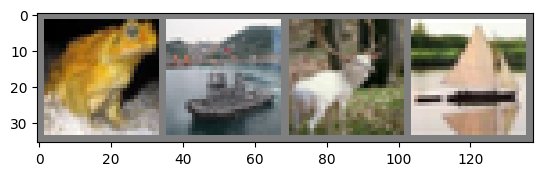

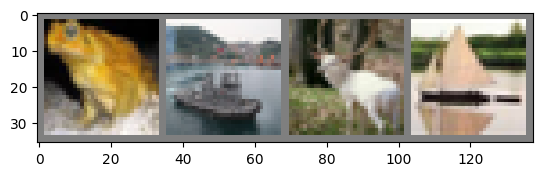

In [25]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [26]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4890254215087053, train acc: 0.46875
 val loss: 1.3254938785065995, val acc: 0.5284352837724888

Epoch 1
 train loss: 1.1937049559744881, train acc: 0.5805489357690271
 val loss: 1.098732188407411, val acc: 0.6200576241980208

Epoch 2
 train loss: 1.0606364370264127, train acc: 0.6302396187616659
 val loss: 1.0476635207521154, val acc: 0.6370789007937655

Epoch 3
 train loss: 0.9944538190770192, train acc: 0.656237757946935
 val loss: 0.9774295484766047, val acc: 0.662344858240574

Epoch 4
 train loss: 0.9568952606408644, train acc: 0.6680391421047818
 val loss: 1.0183901802022406, val acc: 0.6441489361702127

Epoch 5
 train loss: 0.9202108938907575, train acc: 0.6821583638025595
 val loss: 0.925888333929346, val acc: 0.6750443263256803

Epoch 6
 train loss: 0.904413824870338, train acc: 0.6907400758000571
 val loss: 0.9427881172362794, val acc: 0.6737810284533399

Epoch 7
 train loss: 0.8945690484979689, train acc: 0.6900790024283163
 val loss: 0.874707903760544

Посчитайте точность на тестовой выборке:

In [27]:
net.eval()
test_loss, test_accuracy = test(net, test_loader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 0.7946884148060136, Test Accuracy: 0.7302945859872612


__Комментарий:__ Отмечается прирост Accuracy +2% к лучшим моделям без аугментации. Это может быть результатом как и увеличения выборки для обучения, так и снижением переобучения.

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

__Комментарий:__ Существуют следующие походы к аугментации данны:
- RandomRotation - случайно поворачивает изображение на какой-то угол
- GaussianBlur - гауссово размытие изображения
- ColorJitter - случайное изменение яркости, контрастности, оттенка изображения (пример на картинке):
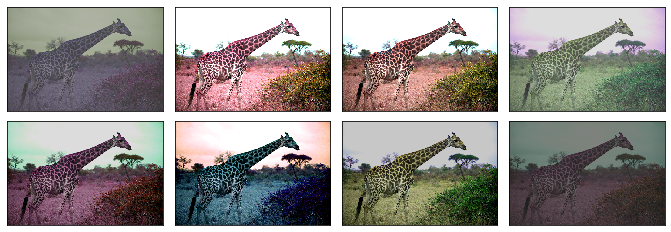

Попробуем каждый вид аугментации по отдельности и потом все три вместе.

In [32]:
transform_rot = transforms.Compose(
    [
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

transform_blur = transforms.Compose(
    [
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

transform_cj = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.15, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

transform_comb = transforms.Compose(
    [
        transforms.RandomRotation(degrees=30),
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader_rot, val_loader_rot, test_loader_rot = get_cifar10_data(
    batch_size=64,
    transform_train=transform_rot
)

train_loader_blur, val_loader_blur, test_loader_blur = get_cifar10_data(
    batch_size=64,
    transform_train=transform_blur
)

train_loader_cj, val_loader_cj, test_loader_cj = get_cifar10_data(
    batch_size=64,
    transform_train=transform_cj
)

train_loader_comb, val_loader_comb, test_loader_comb = get_cifar10_data(
    batch_size=64,
    transform_train=transform_comb
)

In [33]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader_rot, val_loader_rot, scheduler
)

Epoch 0
 train loss: 1.5650932346445114, train acc: 0.4354963763540362
 val loss: 1.3635036595324252, val acc: 0.5078457446808511

Epoch 1
 train loss: 1.3155265847115456, train acc: 0.5317396840839979
 val loss: 1.250755560144465, val acc: 0.5561391845662543

Epoch 2
 train loss: 1.2084491792283067, train acc: 0.574925731261426
 val loss: 1.1647246923852475, val acc: 0.5939494680851064

Epoch 3
 train loss: 1.1391086544589544, train acc: 0.5985652259542475
 val loss: 1.121393860654628, val acc: 0.609219858240574

Epoch 4
 train loss: 1.0931971105840568, train acc: 0.6163285127287591
 val loss: 1.1137538511702354, val acc: 0.6103501773895101

Epoch 5
 train loss: 1.0640481885869935, train acc: 0.6246286563071298
 val loss: 1.0869782196714524, val acc: 0.6209884752618505

Epoch 6
 train loss: 1.039742257738898, train acc: 0.6322514037763397
 val loss: 1.0352478055243797, val acc: 0.6366578015875309

Epoch 7
 train loss: 1.034276195701341, train acc: 0.6341774942016253
 val loss: 1.02222

In [34]:
net.eval()
test_loss, test_accuracy = test(net, test_loader)

print(f"Test Loss (Random Rotation): {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss (Random Rotation): 0.8530653644898895, Test Accuracy: 0.7034235668789809


In [35]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader_cj, val_loader_cj, scheduler
)

Epoch 0
 train loss: 1.5646345621924949, train acc: 0.4423315488006341
 val loss: 1.317997945623195, val acc: 0.537876773134191

Epoch 1
 train loss: 1.2489514258269636, train acc: 0.5613165970694213
 val loss: 1.190765863783816, val acc: 0.5859707446808511

Epoch 2
 train loss: 1.1213107480645397, train acc: 0.6104155785422875
 val loss: 1.1606351127015784, val acc: 0.601484929120287

Epoch 3
 train loss: 1.0751319715048322, train acc: 0.6271178833527364
 val loss: 1.055649670641473, val acc: 0.6291445037151905

Epoch 4
 train loss: 1.0328111375053797, train acc: 0.6430938235148651
 val loss: 1.0389649429219834, val acc: 0.6407579787234042

Epoch 5
 train loss: 0.9990750995806845, train acc: 0.655768477502645
 val loss: 1.0891633728717236, val acc: 0.622872340425532

Epoch 6
 train loss: 0.9798138833568999, train acc: 0.6644277227208208
 val loss: 1.0733509477148664, val acc: 0.6412012412192973

Epoch 7
 train loss: 0.9599294222251152, train acc: 0.6678514299706524
 val loss: 1.006377

In [36]:
net.eval()
test_loss, test_accuracy = test(net, test_loader)

print(f"Test Loss (Color Jitter): {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss (Color Jitter): 0.8534385170906212, Test Accuracy: 0.7091958598726115


In [37]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader_blur, val_loader_blur, scheduler
)

Epoch 0
 train loss: 1.6450274079983587, train acc: 0.41124885740402195
 val loss: 1.471378982320745, val acc: 0.48579343975858486

Epoch 1
 train loss: 1.4245832478542433, train acc: 0.49339334685798103
 val loss: 1.3392188209168454, val acc: 0.5255097518575952

Epoch 2
 train loss: 1.3393158356929828, train acc: 0.5252676939615601
 val loss: 1.3457053443218798, val acc: 0.5197030143534883

Epoch 3
 train loss: 1.2899190686520536, train acc: 0.5448264887171645
 val loss: 1.311026378895374, val acc: 0.548249113559723

Epoch 4
 train loss: 1.2447419370332191, train acc: 0.5595210890883283
 val loss: 1.3165010954471346, val acc: 0.5363031914893617

Epoch 5
 train loss: 1.2080393891229926, train acc: 0.5746237595294904
 val loss: 1.2281732013885012, val acc: 0.5709219859001484

Epoch 6
 train loss: 1.1805356567694893, train acc: 0.583740043138891
 val loss: 1.2381099307790715, val acc: 0.5675531914893617

Epoch 7
 train loss: 1.1627571307109086, train acc: 0.5902487595294904
 val loss: 1.

In [38]:
net.eval()
test_loss, test_accuracy = test(net, test_loader)

print(f"Test Loss (Gaussian Blur): {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss (Gaussian Blur): 1.0078977988024427, Test Accuracy: 0.6556528662420382


In [39]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader_comb, val_loader_comb, scheduler
)

Epoch 0
 train loss: 1.7908511157445541, train acc: 0.35854253723154994
 val loss: 1.6234528181400705, val acc: 0.41136968085106385

Epoch 1
 train loss: 1.6015480078988362, train acc: 0.4264453839667319
 val loss: 1.612604465890438, val acc: 0.4234485816448293

Epoch 2
 train loss: 1.5456321644826607, train acc: 0.44464938634056494
 val loss: 1.5712566035859128, val acc: 0.4440824468085106

Epoch 3
 train loss: 1.5065565756513606, train acc: 0.4634573322327525
 val loss: 1.52066870192264, val acc: 0.46832890079376543

Epoch 4
 train loss: 1.4662102388943352, train acc: 0.4750424393025351
 val loss: 1.4995036008510183, val acc: 0.4633200355032657

Epoch 5
 train loss: 1.443853385051818, train acc: 0.4850442348494172
 val loss: 1.4709909540541628, val acc: 0.4714982269926274

Epoch 6
 train loss: 1.4220422913866897, train acc: 0.4913203513600491
 val loss: 1.5250833967898754, val acc: 0.45509751781504204

Epoch 7
 train loss: 1.3979342288901209, train acc: 0.5020158658079953
 val loss: 

In [40]:
net.eval()
test_loss, test_accuracy = test(net, test_loader)

print(f"Test Loss (Combine): {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss (Combine): 1.1271998198928348, Test Accuracy: 0.6064888535031847


__Комментарий:__ Наилучшие показатели accuracy показали аугментации Color Jitter и Random Rotation, однако итоговая метрика составила около 0.70, что ниже показателя Horizontal Flip. Наиболее слабый результат показал комбинированный метод (accuracy упал до 0.61)

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [41]:
# <your code here>